# Python Import

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

import tensorflow.keras.utils
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping


from google.colab import auth
from google.colab import drive

# Drive Mount

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load Data

In [4]:
train_data = pd.read_csv('/content/drive/MyDrive/cau_temp/train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/cau_temp/test.csv')
sub_data = pd.read_csv('/content/drive/MyDrive/cau_temp/submission.csv')
train_data.head()

,id,digit,letter,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783
0,1,5,L,1,1,1,4,3,0,0,4,4,3,0,4,3,3,3,4,4,0,0,1,1,3,4,0,4,2,0,4,0,1,3,1,0,4,1,1,3,...,4,3,4,1,3,0,0,1,3,3,3,0,3,2,2,1,0,1,0,0,3,0,0,4,2,0,3,4,1,1,2,1,0,1,2,4,4,4,3,4
1,2,0,B,0,4,0,0,4,1,1,1,4,2,0,3,4,0,0,2,3,4,0,3,4,3,0,2,2,1,4,2,3,3,4,1,2,4,2,0,3,...,4,2,3,0,0,0,0,4,3,2,2,4,2,1,1,1,3,3,1,2,4,4,4,2,2,4,4,0,4,2,0,3,0,1,4,1,4,2,1,2
2,3,4,L,1,1,2,2,1,1,1,0,2,1,3,2,2,2,4,1,1,4,1,0,1,3,4,2,2,2,4,1,1,2,0,3,0,2,3,4,0,...,3,0,4,0,3,0,2,0,1,4,2,3,4,4,4,0,2,0,4,4,1,3,0,3,2,0,2,3,0,2,3,3,3,0,2,0,3,0,2,2
3,4,9,D,1,2,0,2,0,4,0,3,4,3,1,0,3,2,2,0,3,4,1,0,4,1,2,2,3,2,2,0,2,0,3,0,3,2,4,0,0,...,0,3,0,1,4,1,3,1,2,1,1,1,2,2,2,4,3,4,3,0,4,1,2,4,1,4,0,1,0,4,3,3,2,0,1,4,0,0,1,1
4,5,6,A,3,0,2,4,0,3,0,4,2,4,2,1,4,1,1,4,4,0,2,3,4,4,3,3,3,3,4,1,0,3,0,3,0,0,0,1,1,...,2,1,3,2,1,4,2,3,2,2,1,0,4,2,2,1,2,1,0,3,2,2,2,2,1,4,2,1,2,1,4,4,3,2,1,3,4,3,1,2


# EDA

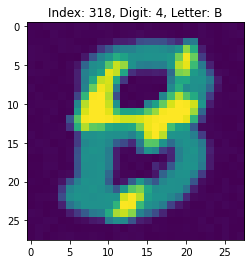

In [14]:
idx = 318
img = train_data.loc[idx, '0':].values.reshape(28, 28).astype(int)
digit = train_data.loc[idx, 'digit']
letter = train_data.loc[idx, 'letter']

plt.title('Index: %i, Digit: %s, Letter: %s'%(idx, digit, letter))
plt.imshow(img)
plt.show()

글자 'B' 안에 숫자 '4'가 보인다.

# Train Model

In [20]:
def x_data(data):
    # drop columns
    cols = [ col for col in data.columns if col in ['id', 'digit', 'letter']]
    x = data.drop(cols, axis=1).values
    # reshape
    x = x.reshape(-1, 28, 28, 1)
    # 정규화
    x = x/255
    return x

def one_hot_encoding(data):
    y = data['digit']
    y_train = np.zeros((len(y), len(y.unique())))
    for i, digit in enumerate(y):
        y_train[i, digit] = 1
    return y_train

In [6]:
x_train = x_data(train_data)
x_test  = x_data(test_data)
y_train = one_hot_encoding(train_data)

In [7]:
model = Sequential()
model.add( Conv2D( 32, kernel_size=(3,3), activation='relu', input_shape=(28,28,1) ) )
model.add( BatchNormalization() )
model.add( Dropout(0.2) )

model.add( Conv2D( 128, kernel_size=(3,3), activation='relu') )
model.add( Dropout(0.2) )

model.add( Conv2D( 128, kernel_size=(3,3), activation='relu') )
model.add( Conv2D( 64, kernel_size=(3,3), activation='relu') )
model.add( MaxPooling2D(pool_size=(2,2)) )
model.add( Flatten() )

model.add( Dense( 32, activation='relu') )
model.add( Dense( 10, activation='softmax') )

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       36992     
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 128)       147584    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 64)        7

In [9]:
model.compile( loss='categorical_crossentropy',
               optimizer='adam',metrics=['accuracy'])

early_stopping = EarlyStopping(patience=20)
hist = model.fit( x_train, y_train, epochs=100, batch_size=40)


Epoch 1/100
52/52 [==============================] - 17s 12ms/step - loss: 2.3230 - accuracy: 0.1221
Epoch 2/100
52/52 [==============================] - 0s 9ms/step - loss: 2.2586 - accuracy: 0.1216
Epoch 3/100
52/52 [==============================] - 0s 9ms/step - loss: 2.1304 - accuracy: 0.1973
Epoch 4/100
52/52 [==============================] - 0s 9ms/step - loss: 1.9928 - accuracy: 0.2251
Epoch 5/100
52/52 [==============================] - 1s 10ms/step - loss: 1.8943 - accuracy: 0.2520
Epoch 6/100
52/52 [==============================] - 0s 9ms/step - loss: 1.7294 - accuracy: 0.3447
Epoch 7/100
52/52 [==============================] - 0s 9ms/step - loss: 1.5672 - accuracy: 0.4170
Epoch 8/100
52/52 [==============================] - 0s 9ms/step - loss: 1.3350 - accuracy: 0.5645
Epoch 9/100
52/52 [==============================] - 0s 9ms/step - loss: 1.1867 - accuracy: 0.5928
Epoch 10/100
52/52 [==============================] - 0s 9ms/step - loss: 1.1033 - accuracy: 0.6206
Epoch 

- loss / acc 그래프 시각화

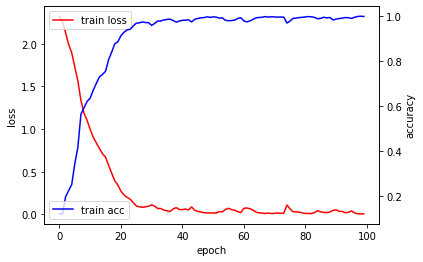

In [10]:
fig, lss = plt.subplots()
acc = lss.twinx()

lss.plot(hist.history['loss'],    'r', label='train loss')
acc.plot(hist.history['accuracy'],'b', label='train acc')

lss.set_xlabel('epoch')
lss.set_ylabel('loss')
acc.set_ylabel('accuracy')

lss.legend(loc='upper left')
acc.legend(loc='lower left')

plt.show()

# Predict

In [18]:
x_test = test_data.drop(['id', 'letter'], axis=1).values
x_test = x_test.reshape(-1, 28, 28, 1)
x_test = x_test/255

sub_data['digit'] = np.argmax(model.predict(x_test), axis=1)
sub_data.to_csv('submission.csv', index=False)
sub_data.head()

,id,digit
0,2049,6
1,2050,3
2,2051,8
3,2052,0
4,2053,3


# File download

In [12]:
from google.colab import files
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>